In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools
import inspect
import time
import os

import numpy as np
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from src import depth
from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points

from tqdm import tqdm

# The Simplicial Complex

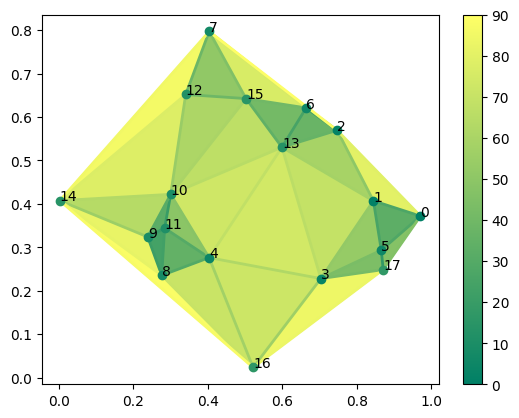

In [3]:
n, dim = 18, 2
points = np.random.random([n, dim])

stree = gh.AlphaComplex(points).create_simplex_tree()
simplices = [simplex for simplex, value in stree.get_filtration()]
filtration_values = np.asarray([value for simplex, value in stree.get_filtration()])
new_filtration_values = np.argsort(filtration_values)
for simplex, value in zip(simplices, new_filtration_values):
    stree.assign_filtration(simplex, value)

sm = plot_filtred_complex2d(stree, points, cmap='summer')
plt.colorbar(sm, ax=plt.gca())
enumerate_points(points)

plt.show()

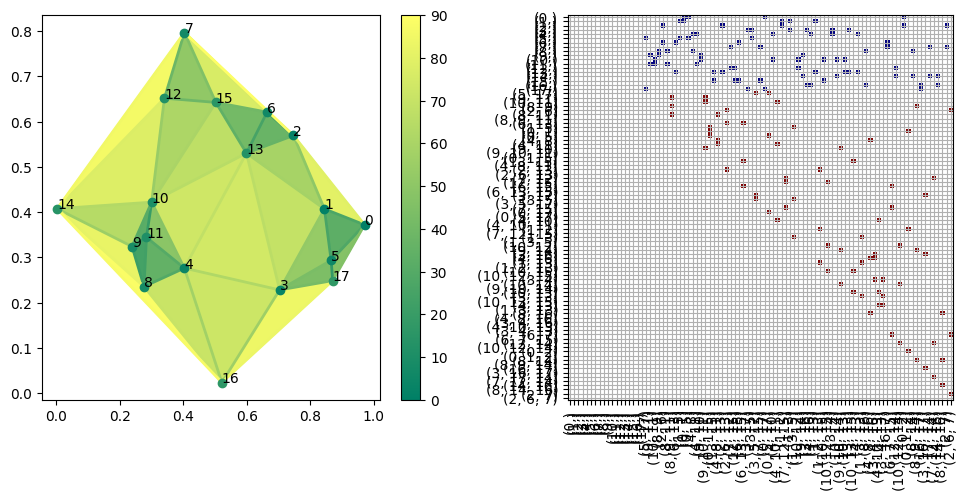

In [4]:
order, matrix = depth.get_ordered_border_matrix_from_simplex_tree(stree)

order_dim = np.array([len(s) - 1 for s in order])

matrix = matrix.astype(float)
matrix[matrix == 0] = np.nan
matrix = matrix*order_dim


fig, axs = plt.subplots(1, 2, figsize=(12, 5))


sm = plot_filtred_complex2d(stree, points, cmap='summer', ax=axs[0])
plt.colorbar(sm, ax=axs[0])
enumerate_points(points, ax=axs[0])


axs[1].imshow(matrix, cmap='jet')
axs[1].set_xticks(np.arange(len(order)), order, rotation=75 if len(order) < 20 else 90)
axs[1].set_yticks(np.arange(len(order)), order, rotation=0)
axs[1].grid(True)

plt.show()

# Define and iterate the Transpositions

In [5]:
def order_is_possible(order):
    # returns False if there are bigger simplices before the smallest
    for i0 in range(len(order)):
        for i1 in range(i0 + 1, len(order)):
            s0 = np.sort(order[i0])
            s1 = np.sort(order[i1])
            intersection = np.intersect1d(s0, s1)
            if list(s1) == list(intersection):
                return False
    return True

In [6]:
def iterate_possible_transpositions_indices(order, neighbours=True):
    # 
    if neighbours:
        generator = np.transpose([np.arange(len(order) - 1), np.arange(len(order) - 1) + 1])
    else:
        generator = itertools.combinations(range(len(order)), 2)
    for i0, i1 in generator:
        new_order = order.copy()
        new_order[i0], new_order[i1] = new_order[i1], new_order[i0]
        if order_is_possible(new_order):
            yield i0, i1

In [7]:
def get_transposition_type(stree: gh.SimplexTree, s0, s1):
    """
    Returns the type of the transpositon (birth-birth, death-deat, birth-death, another) of 2 simplices: s0 and s1
    """
    s0, s1 = tuple(np.sort(s0)), tuple(np.sort(s1))
    try:
        pairs = stree.persistence_pairs()
    except AssertionError:
        stree.compute_persistence()
        pairs = stree.persistence_pairs() 
    births = [tuple(np.sort(pair[0])) for pair in pairs]
    deaths = [tuple(np.sort(pair[1])) for pair in pairs]
    if s0 in births and s1 in births:
        return 'birth-birth'
    if s0 in deaths and s1 in deaths:
        return 'death-death'
    if s0 in births and s1 in deaths:
        return 'birth-death'
    if s0 in deaths and s1 in births:
        return 'birth-death'

In [8]:
def get_transposition(stree: gh.SimplexTree, i0, i1, order=None):
    # 
    if order is None:
        order = [simplex for simplex, value in stree.get_filtration()]
    return {'index 0': i0, 
            'index 1': i1, 
            'value 0': stree.filtration(order[i0]), 
            'value 1': stree.filtration(order[i1]), 
            'simplex 0': order[i0], 
            'simplex 1': order[i1], 
            'dim 0': len(order[i0]) - 1, 
            'dim 1': len(order[i1]) - 1, 
            'type': get_transposition_type(stree, order[i0], order[i1])
           }

In [9]:
def iterate_possible_transpositions(stree: gh.SimplexTree, neighbours=True, transposition_type=None):
    # 
    order = [simplex for simplex, value in stree.get_filtration()]
    for i0, i1 in iterate_possible_transpositions_indices(order, neighbours=neighbours):
        transposition = get_transposition(stree, i0, i1, order=order)
        if (transposition_type is None) or (transposition_type == transposition['type']):
            yield transposition

In [10]:
timer = time.perf_counter()
df_transpositions = pd.DataFrame(iterate_possible_transpositions(stree))
timer = time.perf_counter() - timer

print(f'Transpositions are found in {timer:.4f} seconds.\n')
print(f'Transposition types distribution:\n{
        '\n'.join(str(df_transpositions['type'].value_counts()).split('\n')[1:-1])
        }\n')

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

Transpositions are found in 8.6030 seconds.

Transposition types distribution:
birth-death    26
birth-birth    22
death-death    21

df_transpositions.shape = (69, 9)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth
4,4,5,4.0,5.0,[4],[5],0,0,birth-birth


## Plot the Transposition

In [11]:
def plot_transposition(transposition, stree0, stree1, dp0, dp1, points=points, fig=None, axs=None, 
                       figsize=(9, 8), cmap='summer', layout='persistant'):
    # returns fig, axs
    s0 = transposition['simplex 0']
    s1 = transposition['simplex 1']

    if fig is None or axs is None:
        fig, axs = plt.subplots(2, 2, figsize=figsize)
    
    fig.suptitle(f'The {transposition['type'].replace('b', 'B').replace('d', 'D')} Transposition of Simplices {s0} and {s1}')
    axs[0, 0].set_title('Complex before the Transposition')
    axs[0, 1].set_title('Complex after the Transposition')
    axs[1, 0].set_title('Depth Poset before the Transposition')
    axs[1, 1].set_title('Depth Poset after the Transposition')
    
    
    for i, streei in enumerate([stree0, stree1]):
        sm = plot_filtred_complex2d(streei, points, ax=axs[0, i], cmap=cmap, linewidth=4)
        plt.colorbar(sm, ax=axs[0, i])
    
        plot_simplex(s0, points, ax=axs[0, i], color='red', marker='x', linestyle=':', hatch='+', 
                 label=f'f({s0}) = {streei.filtration(s0)}', zorder=4)
        plot_simplex(s1, points, ax=axs[0, i], color='blue', marker='x', linestyle=':', hatch='+', 
                 label=f'f({s1}) = {streei.filtration(s1)}', zorder=4)
        enumerate_points(points, ax=axs[0, i])
        axs[0, i].legend()

    if layout == 'hasse':
        for i, dpi in enumerate([dp0, dp1]):
            node_color = ['gold' if tuple(s0) in node.source or tuple(s1) in node.source else 'teal' for node in dpi.nodes]
            nx.draw_networkx(dpi.get_transitive_reduction(), pos=dpi.hasse_layout(), ax=axs[1, i], 
                             node_color=node_color, node_size=36, 
                             labels=dpi.get_labels(), 
                             with_labels=True, hide_ticks=True)
    elif layout == 'persistant':
        for i, dpi in enumerate([dp0, dp1]):
            node_color = ['gold' if tuple(s0) in node.source or tuple(s1) in node.source else 'teal' for node in dpi.nodes]
            nx.draw_networkx(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[1, i], 
                             node_color=node_color, node_size=36, 
                             labels=dpi.get_labels(), 
                             with_labels=False, hide_ticks=False)
            axs[1, i].fill_between([0, max(dpi.get_filtration_values())], 
                                   [0, max(dpi.get_filtration_values())], [0, 0], color='lightgrey')
            axs[1, i].set_xlim(*(max(dpi.get_filtration_values())*np.array([-0.05, 1.05])))
            axs[1, i].set_ylim(*(max(dpi.get_filtration_values())*np.array([-0.05, 1.05])))

    return fig, axs

In [12]:
def get_strees(transposition, stree: gh.SimplexTree):
    # returns 2 SimplexTrees, before and after the transposition
    s0, s1 = transposition['simplex 0'], transposition['simplex 1']
    v0, v1 = transposition['value 0'], transposition['value 1']
    stree0 = stree.copy()
    stree1 = stree.copy()
    stree1.assign_filtration(s1, v0)
    stree1.assign_filtration(s0, v1)
    return stree0, stree1

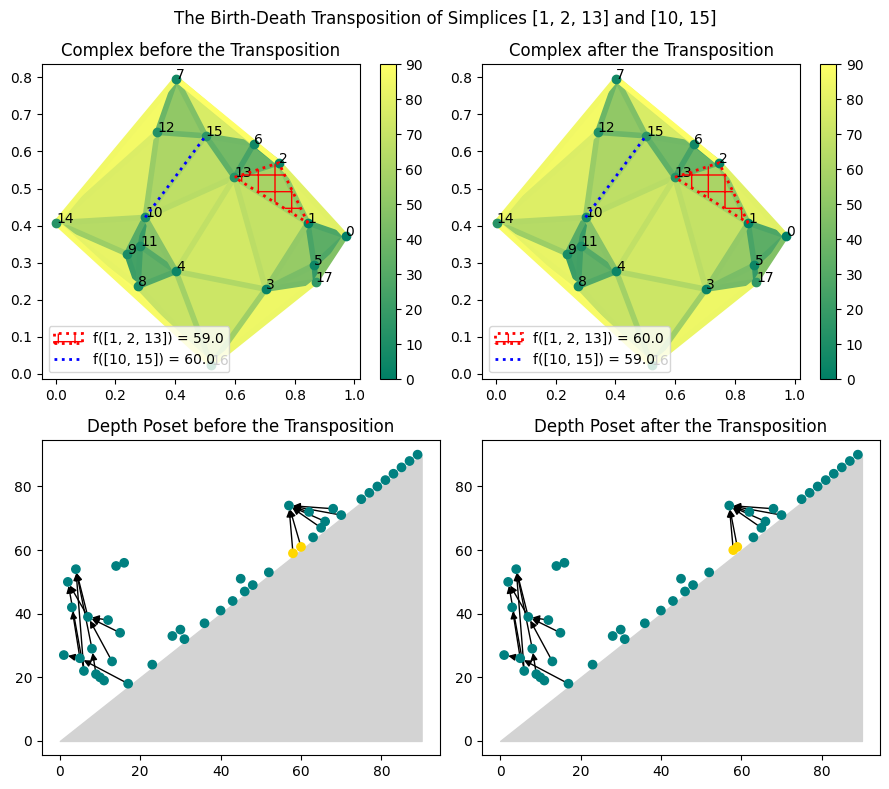

In [13]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions.index)]

stree0, stree1 = get_strees(transposition, stree)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

fig, axs = plot_transposition(transposition, stree0, stree1, dp0, dp1, points=points, cmap='summer')
plt.tight_layout()

plt.show()

## Classifying the Transpositions

In [14]:
def get_xyab_bb(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for birth-birth case
    if transposition['type'] != 'birth-birth':
        return None
    for node in dp0.nodes:
        if node.birth_index == transposition['index 0']:
            a = node.birth_index
            b = node.death_index
        if node.birth_index == transposition['index 1']:
            x = node.birth_index
            y = node.death_index
    return x, y, a, b

def get_xyab_dd(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for death-death case
    if transposition['type'] != 'death-death':
        return None
    for node in dp0.nodes:
        if node.death_index == transposition['index 0']:
            x = node.birth_index
            y = node.death_index
        if node.death_index == transposition['index 1']:
            a = node.birth_index
            b = node.death_index
    return x, y, a, b

def get_xyab_bd(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for birth-death case
    if transposition['type'] != 'birth-death':
        return None
    for node in dp0.nodes:
        if node.death_index == transposition['index 0']:
            a = node.birth_index
            b = node.death_index
        if node.death_index == transposition['index 1']:
            a = node.birth_index
            b = node.death_index
        if node.birth_index == transposition['index 0']:
            x = node.birth_index
            y = node.death_index
        if node.birth_index == transposition['index 1']:
            x = node.birth_index
            y = node.death_index
    return x, y, a, b
    
def get_xyab(transposition, dp0: DepthPoset):
    # 
    try:
        if transposition['type'] == 'birth-birth':
            return get_xyab_bb(transposition, dp0)
        if transposition['type'] == 'death-death':
            return get_xyab_dd(transposition, dp0)
        if transposition['type'] == 'birth-death':
            return get_xyab_bd(transposition, dp0)
    except UnboundLocalError:
        return None

In [15]:
df_transpositions['xyab'] = [get_xyab(transposition, dp0) for i, transposition in df_transpositions.iterrows()]

assert df_transpositions['xyab'].isna().sum() == 1

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

df_transpositions.shape = (69, 10)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type,xyab
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth,None
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth,"(2, 50, 1, 27)"
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth,"(3, 42, 2, 50)"
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth,"(4, 54, 3, 42)"
4,4,5,4.0,5.0,[4],[5],0,0,birth-birth,"(5, 26, 4, 54)"


In [16]:
def get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition, reduce_matrix=True):
    # 
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    try:
        x, y, a, b = get_xyab(transposition, dp0)
    except TypeError:
        return None, None, None

    stop_condition = lambda alpha, b0, delta: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + \
                                              len({(a, x), (x, a), (b, y), (y, b)} & set(b0)) > 0
    if transposition['type'] == 'birth-birth':
        #stop_condition = lambda alpha, b0, delta0: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + len({(b, y), (y, b)} & set (b0)) != 0
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        if reduce_matrix:
            return list(alpha.values()), b0, tuple(map(tuple, delta0[np.sort([x, a])][:, np.sort([y, b])]))
        else:
            return list(alpha.values()), b0, delta0
            
    if transposition['type'] == 'death-death':
        #stop_condition = lambda omega, b1, delta1: len({(a, b), (a, y), (x, b), (x, y)} & set(omega.values())) + len({(a, x), (x, a)} & set (b1)) != 0
        omega, b1, delta1 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)
        if reduce_matrix:
            return list(omega.values()), b1, tuple(map(tuple, delta1[np.sort([x, a])][:, np.sort([y, b])]))
        else:
            return list(omega.values()), b1, delta1
        
    if transposition['type'] == 'birth-death':
        #stop_condition = lambda alpha, b0, delta0: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + len({(b, y), (y, b)} & set (b0)) != 0
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        #stop_condition = lambda omega, b1, delta1: len({(a, b), (a, y), (x, b), (x, y)} & set(omega.values())) + len({(a, x), (x, a)} & set (b1)) != 0
        omega, b1, delta1 = depth.reduct_row_left_to_right(delta0, stop_condition)
        if reduce_matrix:
            return list(alpha.values()) + list(omega.values()), b0 + b1, tuple(map(tuple, delta1[np.sort([a, b, x, y])][:, np.sort([a, b, x, y])]))
        else:
            return list(alpha.values()) + list(omega.values()), b0 + b1, delta1
            

In [17]:
(df_transpositions['bd-pairs'], 
 df_transpositions['relations'], 
 df_transpositions['classifying matrix']) = zip(*[get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition) for i, transposition in df_transpositions.iterrows()])


assert df_transpositions['relations'].isna().sum() == 1
assert df_transpositions['classifying matrix'].isna().sum() == 1

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

df_transpositions.shape = (69, 13)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type,xyab,bd-pairs,relations,classifying matrix
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth,None,None,None,None
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth,"(2, 50, 1, 27)","[(89, 90), (87, 88), (85, 86), (83, 84), (81, ...","[(73, 74), (69, 74), (67, 74), (72, 74), (61, ...","((1, 1), (0, 1))"
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth,"(3, 42, 2, 50)","[(89, 90), (87, 88), (85, 86), (83, 84), (81, ...","[(73, 74), (69, 74), (67, 74), (72, 74), (61, ...","((0, 1), (1, 0))"
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth,"(4, 54, 3, 42)","[(89, 90), (87, 88), (85, 86), (83, 84), (81, ...","[(73, 74), (69, 74), (67, 74), (72, 74), (61, ...","((1, 0), (0, 1))"
4,4,5,4.0,5.0,[4],[5],0,0,birth-birth,"(5, 26, 4, 54)","[(89, 90), (87, 88), (85, 86), (83, 84), (81, ...","[(73, 74), (69, 74), (67, 74), (72, 74), (61, ...","((0, 1), (1, 0))"


In [18]:
def get_switch_type(stree0, dp0, transposition):
    # 
    alpha, omega, matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)

    if transposition['type'] == 'birth-birth':
        if matrix == ((1, 1), 
                      (1, 0)):
            return "switch forward"
        if matrix == ((1, 0), 
                      (1, 1)):
            return "switch backward"
    if transposition['type'] == 'death-death':
        if matrix == ((0, 1), 
                      (1, 1)):
            return "switch forward"
        if matrix == ((1, 0), 
                      (1, 1)):
            return "switch backward"
    if transposition['type'] == 'birth-death':
        if matrix == ((0, 1, 1, 0), 
                      (0, 0, 0, 1), 
                      (0, 0, 0, 1), 
                      (0, 0, 0, 0)):
            return "switch forward"
    return 'no switch'

In [19]:
df_transpositions['switch'] = df_transpositions.apply(lambda row: get_switch_type(stree0, dp0, row), axis=1)

df_transpositions['switch'].value_counts()

switch
no switch          60
switch forward      8
switch backward     1
Name: count, dtype: int64

In [20]:
expected_classifying_matrices = {
    'birth-birth': [((1, 1), 
                     (1, 0)), 
                    ((1, 0), 
                     (1, 1)), 
                    ((0, 1), 
                     (1, 1)), 
                    ((1, 1), 
                     (0, 1)), 
                    ((0, 1), 
                     (1, 0)), 
                    ((1, 0), 
                     (0, 1)),
                    None, 
                   ], 
    'death-death': [((0, 1), 
                     (1, 1)), 
                    ((1, 0), 
                     (1, 1)), 
                    ((1, 1), 
                     (1, 0)), 
                    ((1, 1), 
                     (0, 1)), 
                    ((0, 1), 
                     (1, 0)), 
                    ((1, 0), 
                     (0, 1)), 
                   ],
    'birth-death': [((0, 1, 1, 0), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 0)), 
                    ((0, 1, 0, 0), 
                     (0, 0, 0, 0), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 0)), 
                    ((0, 0, 1, 0), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 0), 
                     (0, 0, 0, 0)), 
                   ]
}

In [21]:
stree

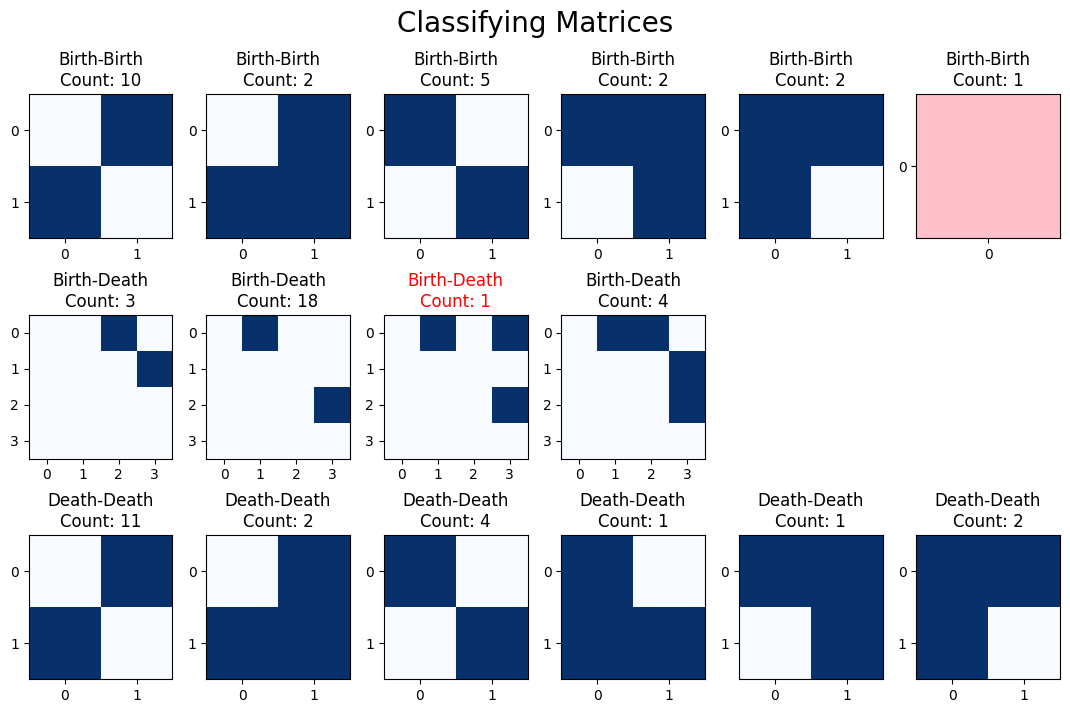

In [22]:
situations = df_transpositions[['type', 'classifying matrix', 'xyab']].fillna('None').rename(columns={'xyab': 'count'})
situations = situations.groupby(['type', 'classifying matrix'], as_index=False).count().replace('None', None)

situations['expected'] = situations.apply(lambda row: row['classifying matrix'] in expected_classifying_matrices[row['type']], axis=1)


n = situations['type'].value_counts().max()
m = len(pd.unique(situations['type']))
fig, axs = plt.subplots(m, n, figsize=(1.8*n, 2.4*m))
fig.suptitle('Classifying Matrices', fontsize=20)

cmap = plt.get_cmap('Blues')
cmap.set_bad(color='pink')

for j, situation_type in enumerate(pd.unique(situations['type'])):
    these_situations = situations[situations['type'] == situation_type].reset_index(drop=True)
    for i, situation in these_situations.iterrows():
        matrix = these_situations.loc[i, 'classifying matrix']
        if matrix is None:
            matrix = np.nan*np.ones([1, 1])
        matrix = np.array(matrix)
        axs[j, i].set_title(f'{situation_type.replace('b', 'B').replace('d', 'D')}\nCount: {situation['count']}', 
                            color='black' if situation['expected'] else 'red')
        axs[j, i].imshow(matrix, cmap=cmap, vmin=0, vmax=1, origin='upper')
        axs[j, i].set_xticks(np.arange(matrix.shape[1]))
        axs[j, i].set_yticks(np.arange(matrix.shape[0]))
    for i in range(len(these_situations), n):
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        for spine in axs[j, i].spines.values():
            spine.set_visible(False)

plt.tight_layout()
plt.show()

In [23]:
df_transpositions['expected'] = df_transpositions.apply(lambda row: row['classifying matrix'] in expected_classifying_matrices[row['type']], axis=1)

print(f"There are {(~df_transpositions['expected']).sum()} unexpected situations.")


There are 1 unexpected situations.


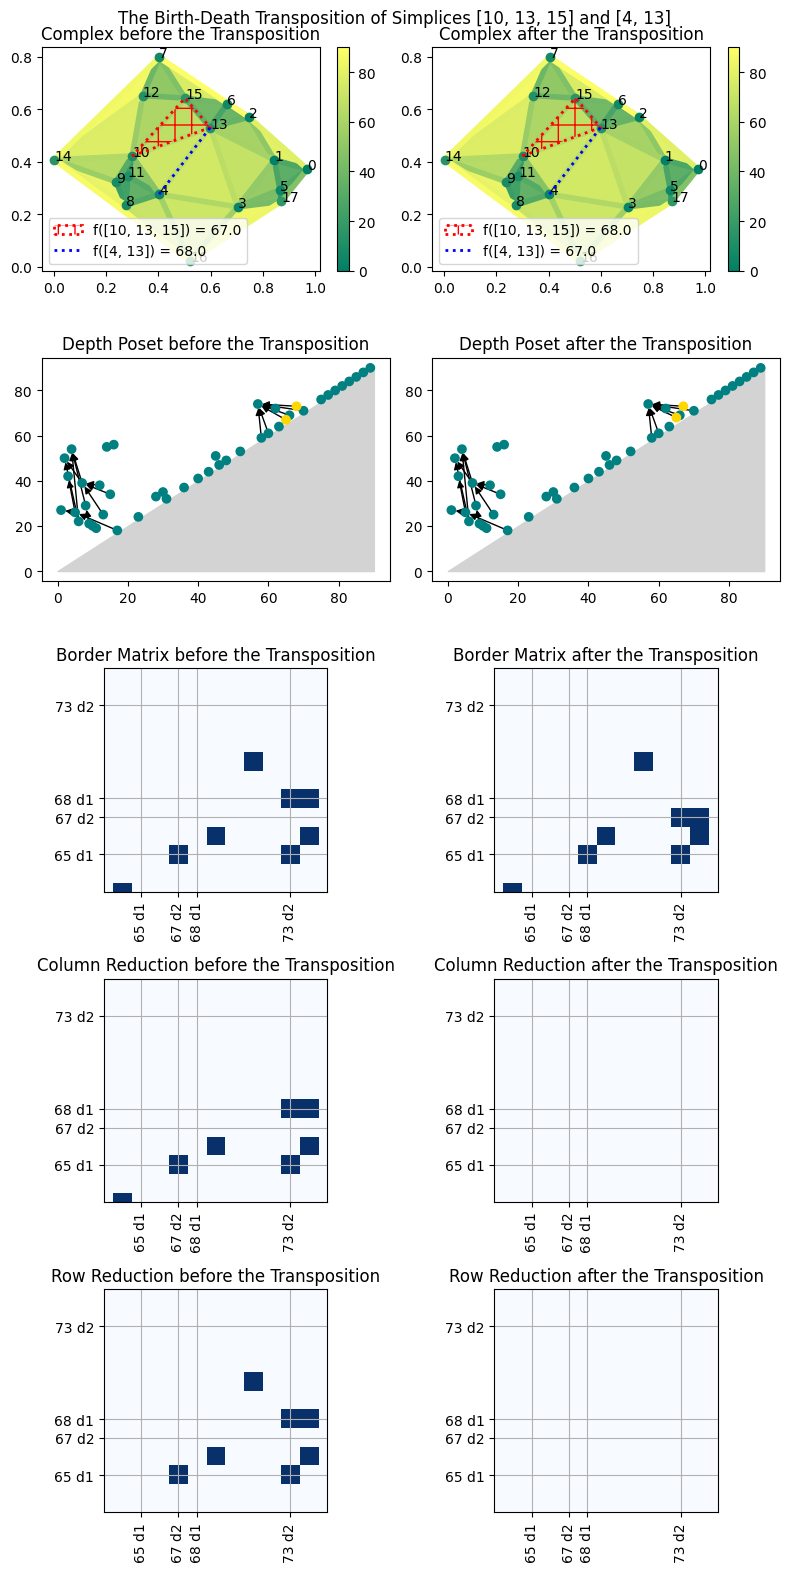

In [24]:
drow_more = True

for i, transposition in df_transpositions[~df_transpositions['expected']].iterrows():
    stree0, stree1 = get_strees(transposition, stree)

    dp0 = DepthPoset.from_simplex_tree(stree0)
    dp1 = DepthPoset.from_simplex_tree(stree1)

    fig, axs = plt.subplots(5, 2, figsize=(8, 16))
    fig, axs = plot_transposition(transposition, stree0, stree1, dp0, dp1, fig=fig, axs=axs)

    x, y, a, b = get_xyab(transposition, dp0)
    assert (np.sort([x, y, a, b]) == np.sort(get_xyab(transposition, dp1))).all()
    
    lim_min = np.min([x, y, a, b]) - 2
    lim_max = np.max([x, y, a, b]) + 3
    extents = [(lim_min, lim_min), 
               (lim_min, lim_max), 
               (lim_max, lim_min), 
               (lim_max, lim_max), 
              ]

    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    order1, border_matrix1 = depth.get_ordered_border_matrix_from_simplex_tree(stree1)

    axs[2, 0].set_title('Border Matrix before the Transposition')
    axs[2, 1].set_title('Border Matrix after the Transposition')
    axs[2, 0].imshow(border_matrix0, cmap='Blues', origin='upper')
    axs[2, 1].imshow(border_matrix1, cmap='Blues', origin='upper')
    
    stop_condition = lambda alpha, b0, delta: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + \
                                              len({(a, x), (x, a), (b, y), (y, b)} & set(b0)) > 0
    alpha0, b00, delta00 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
    alpha1, b01, delta01 = depth.reduct_column_bottom_to_top(border_matrix1, stop_condition)

    axs[3, 0].set_title('Column Reduction before the Transposition')
    axs[3, 1].set_title('Column Reduction after the Transposition')
    axs[3, 0].imshow(delta00, cmap='Blues', origin='upper')
    axs[3, 1].imshow(delta01, cmap='Blues', origin='upper')
    
    omega0, b10, delta10 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)
    omega1, b11, delta11 = depth.reduct_row_left_to_right(border_matrix1, stop_condition)

    axs[4, 0].set_title('Row Reduction before the Transposition')
    axs[4, 1].set_title('Row Reduction after the Transposition')
    axs[4, 0].imshow(delta10, cmap='Blues', origin='upper')
    axs[4, 1].imshow(delta11, cmap='Blues', origin='upper')

    ticks = np.sort([x, y, a, b])
    for j2 in [2, 3, 4]:
        axs[j2, 0].set_xticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=90)
        axs[j2, 0].set_yticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=0)
        axs[j2, 1].set_xticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=90)
        axs[j2, 1].set_yticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=0)
        for j in range(2):
            axs[j2, j].set_xlim(lim_min, lim_max - 1)
            axs[j2, j].set_ylim(lim_min, lim_max - 1)
            axs[j2, j].grid(True)

    plt.tight_layout()
    plt.savefig(f'pics/unexpected_transposition-{i}.png')

    # Show an example only once
    if drow_more:
        plt.show()
        drow_more = False
    else:
        plt.close()

In [25]:
df_transpositions.groupby(['type', 'switch']).count()

index 0  index 1  value 0  value 1  simplex 0  \
type        switch                                                           
birth-birth no switch             20       20       20       20         20   
            switch forward         2        2        2        2          2   
birth-death no switch             22       22       22       22         22   
            switch forward         4        4        4        4          4   
death-death no switch             18       18       18       18         18   
            switch backward        1        1        1        1          1   
            switch forward         2        2        2        2          2   

                             simplex 1  dim 0  dim 1  xyab  bd-pairs  \
type        switch                                                     
birth-birth no switch               20     20     20    19        19   
            switch forward           2      2      2     2         2   
birth-death no switch               22     22     22    22        22   
            switch forward           4      4      4     4         4   
death-death no switch               18     18     18    18        18   
            switch backward          1      1      1     1         1   
            switch forward           2      2      2     2         2   

                             relations  classifying matrix  expected  
type        switch                                                    
birth-birth no switch               19                  19        20  
            switch forward           2                   2         2  
birth-death no switch               22                  22        22  
            switch forward           4                   4         4  
death-death no switch               18                  18        18  
            switch backward          1                   1         1  
            switch forward           2                   2         2

# Basic Set Difference Measures

In [26]:
def jacard_index(a, b):
    """
    Calculate the Jaccard index
    """
    intersection = set(a) & set(b)
    union = set(a) | set(b)
    if len(union) == 0:
        return 1.0
    return len(intersection) / len(union)

# Lemmas and Hypothesises

Write $\text{Succ}(s, t) = \text{Succ}'(s, t) = \text{Succ}''(s, t)$ for the succesors and $\text{Pred}(s, t) = \text{Pred}'(s, t) = \text{Pred}''(s, t)$ for the predecessors (ancessors) of the pair in $D$, $D'$, $D''$, respectively.

Since $D = D' \cup D''$, we also have $\text{Succ}(s, t) = \text{Succ}'(s, t) \cup \text{Succ}''(s, t)$ and $\text{Pred}(s, t) = \text{Pred}'(s, t) \cup \text{Pred}''(s, t)$.

## Lemma 3.1.
Suppose $(x, y)$ and $(a, b)$ are birth-death pairs of $f: X\to R$, $a, x$ are consecutive in the ordering of the cellls by $f$, and the transposition $a, x$ is a switch. Then
$$
\text{Succ}'(a, y) = \{(x, b)\} \cup \text{Succ}'(a, b) \cup \{(s, t)\in \text{Succ}'(x, y) | f(t)<f(b)\}
$$
$$
\text{Succ}'(x, b) = \{(s, t)\in \text{Succ}'(x, y) \oplus \text{Succ}'(a, b) | f(t) > f(b)\}
$$


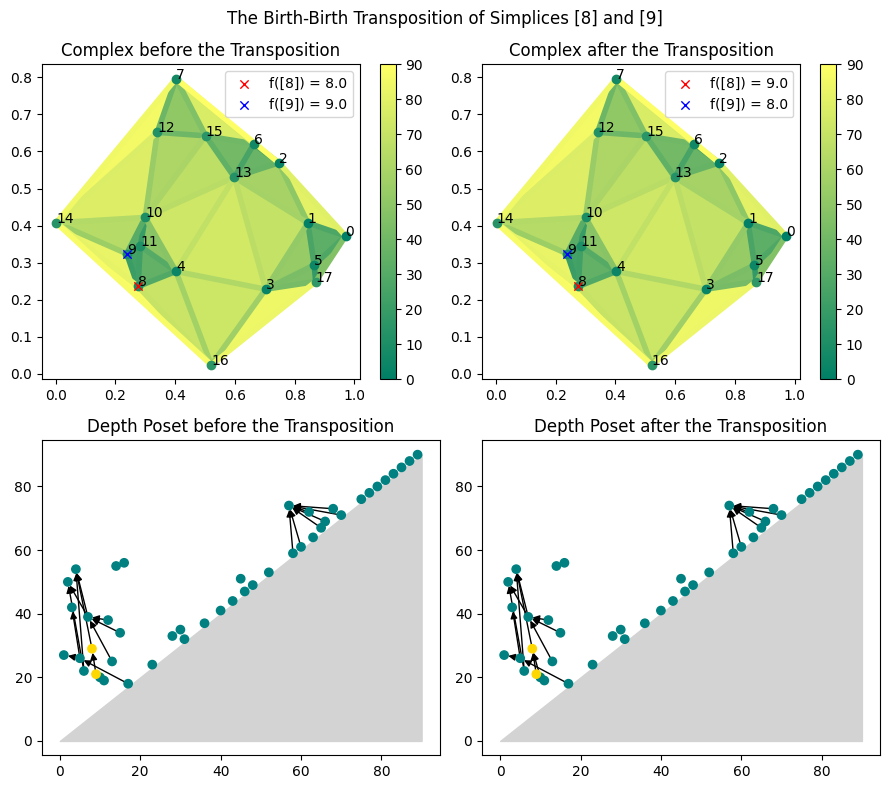

,forward,backward
bd-pairs,"[(89, 90), (87, 88), (85, 86), (83, 84), (81, ...","[(89, 90), (87, 88), (85, 86), (83, 84), (81, ..."
classifying matrix,"((1, 1), (1, 0))","((1, 0), (1, 1))"
dim 0,0,0
dim 1,0,0
expected,True,NaN
index 0,8,8
index 1,9,9
relations,"[(73, 74), (69, 74), (67, 74), (72, 74), (61, ...","[(73, 74), (69, 74), (67, 74), (72, 74), (61, ..."
simplex 0,[8],[9]
simplex 1,[9],[8]


In [27]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[(df_transpositions['type'] == 'birth-birth') &
                                                                         (df_transpositions['switch'] != 'no switch')].index)]

stree0, stree1 = get_strees(transposition, stree)

if transposition['switch'] == 'switch backward':
    print("'switch backward' will be reformated to 'switch forward'")
    transposition = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
    stree0, stree1 = get_strees(transposition, stree1)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

try:
    assert transposition['switch'] == get_switch_type(stree0, dp0, transposition)
except KeyError:
    transposition['switch'] = get_switch_type(stree0, dp0, transposition)
    forward_bd_pairs, forward_relations, forward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)
    transposition['bd-pairs'] = forward_bd_pairs
    transposition['classifying matrix'] = forward_classifying_matrix
    transposition['relations'] = forward_relations    
    transposition['xyab'] = get_xyab(transposition, dp0)

    
transposition_backward = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
transposition_backward['switch'] = get_switch_type(stree1, dp1, transposition_backward)

backward_bd_pairs, backward_relations, backward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree1, dp1, transposition_backward)
transposition_backward['bd-pairs'] = backward_bd_pairs
transposition_backward['classifying matrix'] = backward_classifying_matrix
transposition_backward['relations'] = backward_relations

transposition_backward['xyab'] = get_xyab(transposition_backward, dp1)



fig, axs = plot_transposition(transposition, stree0, stree1, dp0, dp1, cmap='summer')
plt.tight_layout()
plt.show()


pd.DataFrame({'forward': transposition, 
              'backward': transposition_backward})

Let's denote the sets from Lemma:
1. $\text{Succ}'(a, y)$ - __l31_set0__
2. $\{(x, b)\}$ - __l31_set1__
3. $\text{Succ}'(a, b)$ - __l31_set2__
4. $\{(s, t)\in \text{Succ}'(x, y) | f(t)<f(b)\}$ - __l31_set3__
5. $\text{Succ}'(x, b)$ - __l31_set4__
6. $\{(s, t)\in \text{Succ}'(x, y) | f(t) > f(b)\}$ - __l31_set5__

Now the Lemma 3.1 will be look like
$$
    \textbf{l31\_set0} = \textbf{l31\_set1} \cup \textbf{l31\_set2} \cup \textbf{l31\_set3} 
$$
$$
    \textbf{l31\_set4} = \textbf{l31\_set5}
$$

In [28]:
def l31_set0(stree0, stree1, dp0: DepthPoset, dp1: DepthPoset, transposition):
    r"""
    $
    \text{Succ}'(a, y)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_ay = [node for node in dp1.nodes if node.source[0] == sa and node.source[1] == sy][0]

    poset = dp1.get_column_bottom_to_top_reduction()
    node_condition = lambda other: poset.higher(other, node_ay) and (other != node_ay)
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

def l31_set1(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \{(x, b)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    return [(sx, sb)]

def l31_set2(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}'(a, b)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_ab = [node for node in dp0.nodes if node.source[0] == sa and node.source[1] == sb][0]

    poset = dp0.get_column_bottom_to_top_reduction()
    node_condition = lambda other: poset.higher(other, node_ab) and (other != node_ab)
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

def l31_set3(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \{(s, t)\in \text{Succ}'(x, y) | f(t) < f(b)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xy = [node for node in dp0.nodes if node.source[0] == sx and node.source[1] == sy][0]

    poset = dp0.get_column_bottom_to_top_reduction()
    node_condition = lambda other: poset.higher(other, node_xy) and (other != node_xy)
    succ_xy = poset.subposet(node_condition).nodes
    
    res = [node.source for node in succ_xy if node.death_index < b]
    return res 

In [29]:
def jacard_l31a(stree0, stree1, dp0, dp1, transposition):
    r"""
    Jacard Index of $\text{Succ}'(x, b)$ and $\{(a, y)\} \cup \text{Succ}'(a, b) \cup \{(s, t)\in \text{Succ}'(x, y) | f(t) < f(b)\}$
    """
    set0 = l31_set0(stree0, stree1, dp0, dp1, transposition)
    set1 = []
    set1 += l31_set1(stree0, stree1, dp0, dp1, transposition)
    set1 += l31_set2(stree0, stree1, dp0, dp1, transposition)
    set1 += l31_set3(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [30]:
for fl in [l31_set0, l31_set1, l31_set2, l31_set3]:
    seti = fl(stree0, stree1, dp0, dp1, transposition)
    print(fl.__name__, ':', seti)

jacard_l31a(stree0, stree1, dp0, dp1, transposition)

l31_set0 : [((9,), (4, 8)), ((4,), (10, 12))]
l31_set1 : [((9,), (4, 8))]
l31_set2 : [((4,), (10, 12))]
l31_set3 : []


1.0

In [31]:
def l31_set4(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}'(x, b)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xb = [node for node in dp1.nodes if node.source[0] == sx and node.source[1] == sb][0]

    poset = dp1.get_column_bottom_to_top_reduction()
    node_condition = lambda other: poset.higher(other, node_xb) and (other != node_xb)
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

def l31_set5(stree0: gh.SimplexTree, stree1: gh.SimplexTree, dp0, dp1, transposition):
    r"""
    $
    % \{(s, t)\in \text{Succ}'(x, y) \oplus \text{Succ}'(a, b) | f(b) < f(t)\}
    \{(s, t)\in \text{Succ}'(x, y) \cup \text{Succ}'(a, b) | f(b) < f(t)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xy = [node for node in dp0.nodes if node.source[0] == sx and node.source[1] == sy][0]
    node_ab = [node for node in dp0.nodes if node.source[0] == sx and node.source[1] == sy][0]

    poset = dp0.get_column_bottom_to_top_reduction()
    node_condition_xy = lambda other: poset.higher(other, node_xy) and (other != node_xy)
    node_condition_ab = lambda other: poset.higher(other, node_ab) and (other != node_ab)
    succ_xy = [node.source for node in poset.subposet(node_condition_xy).nodes]
    succ_ab = [node.source for node in poset.subposet(node_condition_ab).nodes]

    #res = [node for node in succ_xy if node not in succ_ab] + [node for node in succ_ab if node not in succ_xy]
    res = succ_xy + succ_ab
    res = [node for node in res if stree0.filtration(node[1]) > b]
    return res 

In [32]:
def jacard_l31b(stree0, stree1, dp0, dp1, transposition):
    r"""
    % Jacard Index of $\text{Succ}'(x, b)$ and $\{(s, t)\in \text{Succ}'(x, y) \oplus \text{Succ}'(a, b) | f(t) > f(b)\}$
    Jacard Index of $\text{Succ}'(x, b)$ and $\{(s, t)\in \text{Succ}'(x, y) \cup \text{Succ}'(a, b) | f(t) > f(b)\}$
    """
    set0 = l31_set4(stree0, stree1, dp0, dp1, transposition)
    set1 = l31_set5(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [33]:
for fl in [l31_set4, l31_set5]:
    seti = fl(stree0, stree1, dp0, dp1, transposition)
    print(fl.__name__, ':', seti)

jacard_l31b(stree0, stree1, dp0, dp1, transposition)

l31_set4 : [((4,), (10, 12))]
l31_set5 : [((4,), (10, 12)), ((4,), (10, 12))]


1.0

## Lemma 3.2.
Suppose $(a, b)$ and $(x, y)$ are birth-death pairs of $f:X\to R$, $y, b$ are consecutive in the ordering by $f$, and transposition of $y, b$ is a switch. Then
$$
\text{Succ}''(x, b) = \{(a, y)\} \cup \text{Succ}''(a, b) \cup \{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s)\}
$$
$$
\text{Succ}''(a, y) = \{(s, t)\in\text{Succ}''(x, y) | f(s) < f(a)\}
$$


In [34]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[(df_transpositions['type'] == 'death-death') &
                                                                         (df_transpositions['switch'] != 'no switch')].index)]

stree0, stree1 = get_strees(transposition, stree)

if transposition['switch'] == 'switch backward':
    print("'switch backward' will be reformated to 'switch forward'")
    transposition = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
    stree0, stree1 = get_strees(transposition, stree1)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

try:
    assert transposition['switch'] == get_switch_type(stree0, dp0, transposition)
except KeyError:
    transposition['switch'] = get_switch_type(stree0, dp0, transposition)
    forward_bd_pairs, forward_relations, forward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)
    transposition['bd-pairs'] = forward_bd_pairs
    transposition['classifying matrix'] = forward_classifying_matrix
    transposition['relations'] = forward_relations    
    transposition['xyab'] = get_xyab(transposition, dp0)

    
transposition_backward = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
transposition_backward['switch'] = get_switch_type(stree1, dp1, transposition_backward)

backward_bd_pairs, backward_relations, backward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree1, dp1, transposition_backward)
transposition_backward['bd-pairs'] = backward_bd_pairs
transposition_backward['classifying matrix'] = backward_classifying_matrix
transposition_backward['relations'] = backward_relations

transposition_backward['xyab'] = get_xyab(transposition_backward, dp1)


pd.DataFrame({'forward': transposition, 
              'backward': transposition_backward})

,forward,backward
bd-pairs,"[(17, 18), (11, 19), (10, 20), (9, 21), (6, 22...","[(17, 18), (11, 19), (10, 20), (9, 21), (6, 22..."
classifying matrix,"((0, 1), (1, 1))","((1, 0), (1, 1))"
dim 0,2,2
dim 1,2,2
expected,True,NaN
index 0,73,73
index 1,74,74
relations,"[(17, 5), (11, 9), (10, 9), (9, 8), (6, 2), (1...","[(17, 5), (11, 9), (10, 9), (9, 8), (6, 2), (1..."
simplex 0,"[4, 10, 13]","[3, 4, 13]"
simplex 1,"[3, 4, 13]","[4, 10, 13]"


Let's denote these sets:
1. $\text{Succ}''(x, b)$ - __l32_set0__
2. $\{(a, y)\}$ - __l32_set1__
3. $\text{Succ}''(a, b)$ - __l32_set2__
4. $\{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s)\}$ - __l32_set3__
5. $\text{Succ}''(a, y)$ - __l32_set4__
6. $\{(s, t)\in \text{Succ}''(x, y) | f(s) < f(a)\}$ - __l32_set5__

Now the Lemma 3.2 will be look like
$$
    \textbf{l32\_set0} = \textbf{l32\_set1} \cup \textbf{l32\_set2} \cup \textbf{l32\_set3} 
$$
$$
    \textbf{l32\_set4} = \textbf{l32\_set5}
$$

In [35]:
def l32_set0(stree0, stree1, dp0: DepthPoset, dp1: DepthPoset, transposition):
    r"""
    $
    \text{Succ}''(x, b)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xb = [node for node in dp1.nodes if node.source[0] == sx and node.source[1] == sb][0]

    poset = dp1.get_row_left_to_right_reduction()
    node_condition = lambda other: poset.higher(other, node_xb) and other != node_xb
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

def l32_set1(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \{(a, y)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    return [(sa, sy)]

def l32_set2(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}''(a, b)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_ab = [node for node in dp0.nodes if node.source[0] == sa and node.source[1] == sb][0]

    poset = dp0.get_row_left_to_right_reduction()
    node_condition = lambda other: poset.higher(other, node_ab) and other != node_ab
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

def l32_set3(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s) \}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xy = [node for node in dp0.nodes if node.source[0] == sx and node.source[1] == sy][0]

    poset = dp0.get_row_left_to_right_reduction()
    node_condition = lambda other: poset.higher(other, node_xy) and (other != node_xy)
    succ_xy = poset.subposet(node_condition).nodes
    
    res = [node.source for node in succ_xy if a < node.birth_index]
    return res 

In [36]:
def jacard_l32a(stree0, stree1, dp0, dp1, transposition):
    r"""
    Jacard Index of $\text{Succ}''(x, b)$ and $\{(a, y)\} \cup \text{Succ}''(a, b) \cup \{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s) < f(x)\}$
    """
    set0 = l32_set0(stree0, stree1, dp0, dp1, transposition)
    set1 = []
    set1 += l32_set1(stree0, stree1, dp0, dp1, transposition)
    set1 += l32_set2(stree0, stree1, dp0, dp1, transposition)
    set1 += l32_set3(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [37]:
for fl in [l32_set0, l32_set1, l32_set2, l32_set3]:
    seti = fl(stree0, stree1, dp0, dp1, transposition)
    print(fl.__name__, ':', seti)

jacard_l32a(stree0, stree1, dp0, dp1, transposition)

l32_set0 : [((4, 16), (4, 10, 13))]
l32_set1 : [((4, 16), (4, 10, 13))]
l32_set2 : []
l32_set3 : []


1.0

In [38]:
def l32_set4(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}''(a, b)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    #node_ay = [node for node in dp1.nodes if node.source[0] == sa and node.source[1] == sy][0]
    node_ab = [node for node in dp0.nodes if node.source[0] == sa and node.source[1] == sb][0]


    #poset = dp1.get_row_left_to_right_reduction()
    #node_condition = lambda other: poset.higher(other, node_ay) and other != node_ay
    poset = dp0.get_row_left_to_right_reduction()
    node_condition = lambda other: poset.higher(other, node_ab) and other != node_ab
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

def l32_set5(stree0: gh.SimplexTree, stree1: gh.SimplexTree, dp0, dp1, transposition):
    r"""
    $
    % \{(s, t)\in \text{Succ}''(x, y) \oplus \text{Succ}''(a, b) | f(s) < f(a)\}
    \{(s, t)\in \text{Succ}''(x, y) \cup \text{Succ}''(a, b) | f(s) < f(a)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xy = [node for node in dp0.nodes if node.source[0] == sx and node.source[1] == sy][0]
    node_ab = [node for node in dp0.nodes if node.source[0] == sa and node.source[1] == sb][0]

    poset = dp0.get_row_left_to_right_reduction()
    node_condition_xy = lambda other: poset.higher(other, node_xy) and (other != node_xy)
    node_condition_ab = lambda other: poset.higher(other, node_ab) and (other != node_ab)
    succ_xy = [node.source for node in poset.subposet(node_condition_xy).nodes]
    succ_ab = [node.source for node in poset.subposet(node_condition_ab).nodes]
    #print(f'succ_xy: {succ_xy}, where xy = ({node_xy})')
    #print(f'succ_ab: {succ_ab}, where ab = ({node_ab})')
    
    
    #res = [node for node in succ_xy if node not in succ_ab] + [node for node in succ_ab if node not in succ_xy]
    res = succ_xy + succ_ab
    #print(f'res: {res}')
    res = [node for node in res if stree0.filtration(node[0]) < a]
    return res 

In [39]:
def jacard_l32b(stree0, stree1, dp0, dp1, transposition):
    r"""
    % Jacard Index of $\text{Succ}''(a, y)$ and $\{(s, t)\in \text{Succ}''(x, y) \oplus \text{Succ}''(a, b) | f(s) < f(a)\}$
    Jacard Index of $\text{Succ}''(a, y)$ and $\{(s, t)\in \text{Succ}''(x, y) \cup \text{Succ}''(a, b) | f(s) < f(a)\}$
    """
    set0 = l32_set4(stree0, stree1, dp0, dp1, transposition)
    set1 = l32_set5(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [40]:
for fl in [l32_set4, l32_set5]:
    seti = fl(stree0, stree1, dp0, dp1, transposition)
    print(f'{fl.__name__}: {seti}')

jacard_l32b(stree0, stree1, dp0, dp1, transposition)

l32_set4: []
l32_set5: []


1.0

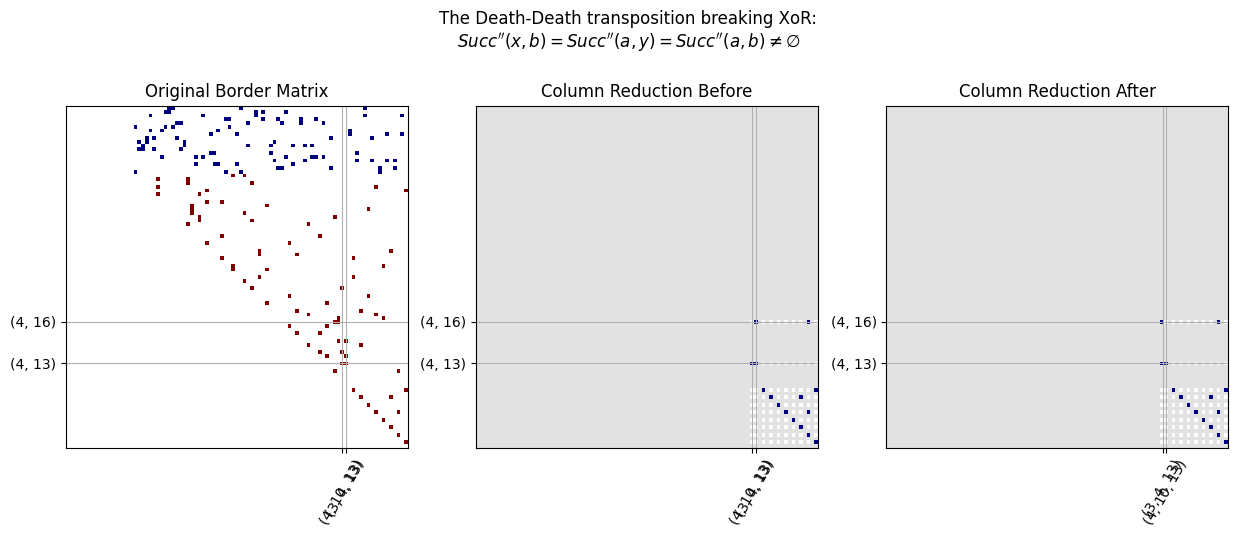

In [41]:
order, matrix = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
order_dim = [len(s) - 1 for s in order]

matrix_plot = matrix.astype(float)
matrix_plot[matrix == 0] = np.nan
matrix_plot *= order_dim


omega, beta1, delta = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition, reduce_matrix=False)
delta_plot = delta.astype(float)
delta_plot[delta == 0] = np.nan
delta_plot *= order_dim

omega, beta1, delta2 = get_transposition_relations_and_classifying_matrix(stree1, dp1, transposition_backward, reduce_matrix=False)
delta2_plot = delta2.astype(float)
delta2_plot[delta2 == 0] = np.nan
delta2_plot *= order_dim

fig, axs = plt.subplots(1, 3, figsize=(15, 5.5))
fig.suptitle(f"The Death-Death transposition breaking XoR:\n$Succ''(x, b) = Succ''(a, y) = Succ''(a, b) \\ne \\emptyset$")

axs[0].set_title('Original Border Matrix')
axs[1].set_title('Column Reduction Before')
axs[2].set_title('Column Reduction After')

axs[0].imshow(matrix_plot, cmap='jet')
axs[1].imshow(delta_plot, cmap='jet')
axs[2].imshow(delta2_plot, cmap='jet')


c_del = 0.15
deleted = 0.2*np.ones(delta.shape)
deleted[(delta != 0).any(axis=1), :] = np.nan
axs[1].imshow(deleted, cmap='Grays', vmin=0, vmax=1)
deleted = 0.2*np.ones(delta.shape)
deleted[:, (delta != 0).any(axis=0)] = np.nan
axs[1].imshow(deleted, cmap='Grays', vmin=0, vmax=1)

deleted = 0.2*np.ones(delta.shape)
deleted[(delta2 != 0).any(axis=1), :] = np.nan
axs[2].imshow(deleted, cmap='Grays', vmin=0, vmax=1)
deleted = 0.2*np.ones(delta.shape)
deleted[:, (delta2 != 0).any(axis=0)] = np.nan
axs[2].imshow(deleted, cmap='Grays', vmin=0, vmax=1)



x, y, a, b = get_xyab(transposition, dp0)

for i in range(3):
    axs[i].set_xticks([y, b], np.array(order, dtype=object)[[y, b]], rotation=60)
    axs[i].set_yticks([x, a], np.array(order, dtype=object)[[x, a]], rotation=0)
    axs[i].grid(True)
axs[2].set_xticks([y, b], np.array(order, dtype=object)[[b, y]], rotation=60)

plt.savefig(f'pics/dd-transposition breaking xor.png')


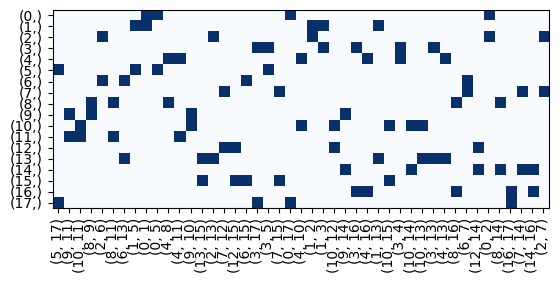

In [42]:
plt.imshow(matrix[np.array(order_dim) == 0, :][:, np.array(order_dim) == 1], cmap='Blues')

plt.yticks(np.arange((np.array(order_dim) == 0).sum()), labels=np.array(order, dtype=object)[np.array(order_dim) == 0], rotation=0)
plt.xticks(np.arange((np.array(order_dim) == 1).sum()), labels=np.array(order, dtype=object)[np.array(order_dim) == 1], rotation=90)

plt.savefig(f'pics/dd-transposition breaking xor dim 0-1.png')

## Lemma 3.3.
Suppose $(a, b)$ and $(x, y)$ are birth-death pairs of $f$: $X\to R$, $b, x$ are consecutive in the ordering by $f$, and the transposition of $b, x$ is a switch. Then
$$
\text{Succ}(a, x) = \text{Succ}(a, b)
\;\;\text{and}\;\; 
\text{Succ}(b, y) = \text{Succ}(x, y)
$$
$$
\text{Pred}(a, x) = \{(s, t) | t\in \text{Col}(a, x)\} \cup \text{Pred}''(a, b)
$$
$$
\text{Pred}(b, y) = \{(s, t) | t\in \text{Row}(b, y)\} \cup \text{Pred}''(x, y)
$$


In [43]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[(df_transpositions['type'] == 'birth-death') &
                                                                         (df_transpositions['switch'] != 'no switch')].index)]

stree0, stree1 = get_strees(transposition, stree)

if transposition['switch'] == 'switch backward':
    print("'switch backward' will be reformated to 'switch forward'")
    transposition = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
    stree0, stree1 = get_strees(transposition, stree1)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

try:
    assert transposition['switch'] == get_switch_type(stree0, dp0, transposition)
except KeyError:
    transposition['switch'] = get_switch_type(stree0, dp0, transposition)
    forward_bd_pairs, forward_relations, forward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)
    transposition['bd-pairs'] = forward_bd_pairs
    transposition['classifying matrix'] = forward_classifying_matrix
    transposition['relations'] = forward_relations    
    transposition['xyab'] = get_xyab(transposition, dp0)

    
transposition_backward = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
transposition_backward['switch'] = get_switch_type(stree1, dp1, transposition_backward)

backward_bd_pairs, backward_relations, backward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree1, dp1, transposition_backward)
transposition_backward['bd-pairs'] = backward_bd_pairs
transposition_backward['classifying matrix'] = backward_classifying_matrix
transposition_backward['relations'] = backward_relations

transposition_backward['xyab'] = get_xyab(transposition_backward, dp1)


pd.DataFrame({'forward': transposition, 
              'backward': transposition_backward})

,forward,backward
bd-pairs,"[(89, 90), (87, 88), (85, 86), (83, 84), (81, ...","[(89, 90), (87, 88), (85, 86), (83, 84), (81, ..."
classifying matrix,"((0, 1, 1, 0), (0, 0, 0, 1), (0, 0, 0, 1), (0,...","((0, 1, 1, 0), (0, 0, 0, 1), (0, 0, 0, 1), (0,..."
dim 0,1,1
dim 1,1,1
expected,True,NaN
index 0,42,42
index 1,43,43
relations,"[(73, 74), (69, 74), (67, 74), (72, 74), (61, ...","[(73, 74), (69, 74), (67, 74), (72, 74), (61, ..."
simplex 0,"[3, 17]","[3, 5]"
simplex 1,"[3, 5]","[3, 17]"


Let's again rename the sets:
1. $\text{Succ}(a, x)$ - __l33_set0__ 
1. $\text{Succ}(a, b)$ - __l33_set1__ 
1. $\text{Succ}(b, y)$ - __l33_set2__ 
1. $\text{Succ}(x, y)$ - __l33_set3__ 

In [44]:
def l33_set0(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}(a, x)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_ax = [node for node in dp1.nodes if node.source[0] == sa and node.source[1] == sx][0]
    
    node_condition = lambda other: dp1.higher(other, node_ax) and other != node_ax
    poset = dp1.subposet(node_condition)

    return [node.source for node in poset.nodes]

def l33_set1(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}(a, b)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_ab = [node for node in dp0.nodes if node.source[0] == sa and node.source[1] == sb][0]
    
    node_condition = lambda other: dp0.higher(other, node_ab) and other != node_ab
    poset = dp0.subposet(node_condition)

    return [node.source for node in poset.nodes]

In [45]:
def jacard_l33a(stree0, stree1, dp0, dp1, transposition):
    r"""
    Jacard Index of $\text{Succ}(a, x)$ and $\text{Succ}(a, b)$
    """
    set0 = l33_set0(stree0, stree1, dp0, dp1, transposition)
    set1 = l33_set1(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [46]:
for fl in [l33_set0, l33_set1]:
    seti = fl(stree0, stree1, dp0, dp1, transposition)
    print(fl.__name__, ':', seti)

jacard_l33a(stree0, stree1, dp0, dp1, transposition)

l33_set0 : []
l33_set1 : []


1.0

In [47]:
def l33_set2(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}(b, y)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_by = [node for node in dp1.nodes if node.source[0] == sb and node.source[1] == sy][0]
    
    node_condition = lambda other: dp1.higher(other, node_by) and other != node_by
    poset = dp1.subposet(node_condition)

    return [node.source for node in poset.nodes]

def l33_set3(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}(x, y)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xy = [node for node in dp0.nodes if node.source[0] == sx and node.source[1] == sy][0]
    
    node_condition = lambda other: dp0.lower(other, node_xy) and other != node_xy
    poset = dp0.subposet(node_condition)

    return [node.source for node in poset.nodes]

In [48]:
def jacard_l33b(stree0, stree1, dp0, dp1, transposition):
    r"""
    Jacard Index of $\text{Succ}(b, y)$ and $\text{Succ}(x, y)$
    """
    set0 = l33_set0(stree0, stree1, dp0, dp1, transposition)
    set1 = l33_set1(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [49]:
for fl in [l33_set2, l33_set3]:
    seti = fl(stree0, stree1, dp0, dp1, transposition)
    print(fl.__name__, ':', seti)

jacard_l33b(stree0, stree1, dp0, dp1, transposition)

l33_set2 : []
l33_set3 : []


1.0

## General Scores

In [50]:
def jacard_nodes_filtration(dp0: DepthPoset, dp1: DepthPoset):
    r"""
    The Jacard index of node sets from 2 depth posets.
    The birth-death pairs are equal in terms of filtration values.
    """
    set0 = [(node.birth_value, node.death_value) for node in dp0.nodes]
    set1 = [(node.birth_value, node.death_value) for node in dp1.nodes]
    return jacard_index(set0, set1)

In [51]:
def jacard_nodes_simplex(dp0: DepthPoset, dp1: DepthPoset):
    r"""
    The Jacard index of nodes from 2 depth posets.
    The birth-death pairs are equal in terms of simplices.
    """
    set0 = [node.source for node in dp0.nodes]
    set1 = [node.source for node in dp1.nodes]
    return jacard_index(set0, set1)

In [52]:
def jacard_edges_filtration(dp0: DepthPoset, dp1: DepthPoset):
    r"""
    The Jacard index of edge sets from transitive reductions of 2 depth posets.
    The birth-death pairs are equal in terms of filtration values.
    """
    g0 = dp0.get_transitive_reduction()
    g1 = dp1.get_transitive_reduction()

    set0 = [((n0.birth_value, n0.death_value), (n1.birth_value, n1.death_value)) for n0, n1 in g0.edges]
    set1 = [((n0.birth_value, n0.death_value), (n1.birth_value, n1.death_value)) for n0, n1 in g1.edges]
    return jacard_index(set0, set1)

In [53]:
def jacard_edges_simplex(dp0: DepthPoset, dp1: DepthPoset):
    r"""
    The Jacard index of edge sets from transitive reductions of 2 depth posets.
    The birth-death pairs are equal in terms of simplices.
    """
    g0 = dp0.get_transitive_reduction()
    g1 = dp1.get_transitive_reduction()

    set0 = [(n0.source, n1.source) for n0, n1 in g0.edges]
    set1 = [(n0.source, n1.source) for n0, n1 in g1.edges]
    return jacard_index(set0, set1)

## Hypothesis 1: 
Suppose $a$ and $b$ are 2-simplices consecutive in the ordering by $f$. And there is another Morse function $f^*$: 
$$
f^*(s) = 
\begin{cases}
f(s), \; \text{if} \; s\ne a, b \\
f(b), \; \text{if} \; s = a \\
f(a), \; \text{if} \; s = b
\end{cases}
$$
Let's denote $DP_{f}$ the transitive reduction of the Depth Poset defined by the filtration $f$. And let's deonote $DP_{f}(s)$ the set of nodes in $DP_f(s)$ which are pairs containing cell $s$ and the set of edges with these nodes.

__Hypothesis:__ if the cell $s$ has no faces and cofaces with $a$ and $b$, then $DP_f(s) = DP_{f^*}(s)$.

In [54]:
def unique(input_list):
    """
    Returns the list of unique elements in input_list
    """
    seen = set()
    result = []
    
    for elem in input_list:
        if isinstance(elem, np.ndarray):
            # Convert np.array to a tuple for hashable representation
            identifier = (np.ndarray, elem.shape, tuple(elem.ravel()))
        else:
            # Use the element directly for hashable types
            identifier = elem
        
        # Check for uniqueness
        if identifier not in seen:
            seen.add(identifier)
            result.append(elem)
    
    return result

In [55]:
def is_face_coface_pair(face, coface):
    """
    Returns True if the given pair of simolices are face and coface to each other
    """
    if len(face) + 1 != len(coface):
        return False
    return tuple(np.sort(face)) == tuple(np.sort(np.intersect1d(face, coface)))

In [56]:
def get_faces(simplices, coface):
    """
    """
    res = []
    for simplex in simplices:
        if is_face_coface_pair(simplex, coface):
            res.append(simplex)
    return res

In [57]:
def get_cofaces(simplices, face):
    """
    """
    res = []
    for simplex in simplices:
        if is_face_coface_pair(face, simplex):
            res.append(simplex)
    return res

In [58]:
def get_cofaces_of_faces(simplices, simplex):
    """
    """
    res = []
    for face in get_faces(simplices, simplex):
        res += list(get_cofaces(simplices, face))
    return unique(res)

In [59]:
def get_faces_of_cofaces(simplices, simplex):
    """
    """
    res = []
    for coface in get_cofaces(simplices, simplex):
        res += list(get_faces(simplices, coface))
    return unique(res)

In [60]:
def exclude_transposition_from_nodes(nodes, s0, s1, simplices=None):
    """
    Returns the list of nodes, filtered, that node simplices are not transposition neighbours.
    Two simplices are neighbours, if they have one face or coface.
    """
    if simplices is None:
        simplices = unique([node.source[0] for node in nodes] + [node.source[1] for node in nodes])
    
    simplices_to_exclude = unique(get_cofaces_of_faces(simplices, s0) + \
                                  get_cofaces_of_faces(simplices, s1) + \
                                  get_faces_of_cofaces(simplices, s0) + \
                                  get_faces_of_cofaces(simplices, s1) )
    node_condition = lambda node: node.source[0] not in simplices_to_exclude and node.source[1] not in simplices_to_exclude
    
    return [node for node in nodes if node_condition(node)]

In [61]:
def exclude_transposition_from_edges(edges, s0, s1, simplices=None):
    """
    Returns the list of edges, filtered, that node simplices are not transposition neighbours.
    Two simplices are neighbours, if they have one face or coface.
    """
    if simplices is None:
        simplices = []
        for edge in edges:
            simplices += [node.source[0] for node in edge] + [node.source[1] for node in edge]
        simplices = unique(simplices)
    
    simplices_to_exclude = unique(get_cofaces_of_faces(simplices, s0) + \
                                  get_cofaces_of_faces(simplices, s1) + \
                                  get_faces_of_cofaces(simplices, s0) + \
                                  get_faces_of_cofaces(simplices, s1) )
    node_condition = lambda node: node.source[0] not in simplices_to_exclude and node.source[1] not in simplices_to_exclude
    edge_condition = lambda edge: node_condition(edge[0]) and node_condition(edge[1])
    
    return [edge for edge in edges if edge_condition(edge)]

In [62]:
def jacard_nn_nodes(dp0: DepthPoset, dp1: DepthPoset, transposition):
    r"""
    The Jacard index of subsets of nodes $(s, t)$ from 2 depth posets, s.t. 
    $s, t \notin \nabla\partial\sigma_0 \cup \partial\nabla\sigma_0 \cup \nabla\partial\sigma_1 \cup \partial\nabla\sigma_1$,
    where $\sigma_0$ and $\sigma_1$ are transposing simplices.
    """
    s0, s1 = transposition[['simplex 0', 'simplex 1']]

    set0 = exclude_transposition_from_nodes(dp0.nodes, s0, s1)
    set1 = exclude_transposition_from_nodes(dp1.nodes, s0, s1)

    return jacard_index(set0, set1)

In [63]:
jacard_nn_nodes(dp0, dp1, transposition)

1.0

In [64]:
def jacard_nn_edges(dp0: DepthPoset, dp1: DepthPoset, transposition):
    r"""
    The Jacard index of subsets of edges $((s_0, t_0), (s_1, t_1))$ from 2 depth posets, s.t. 
    $s_0, t_0, s_1, t_1 \notin \nabla\partial\sigma_0 \cup \partial\nabla\sigma_0 \cup \nabla\partial\sigma_1 \cup \partial\nabla\sigma_1$,
    where $\sigma_0$ and $\sigma_1$ are transposing simplices.
    """
    s0, s1 = transposition[['simplex 0', 'simplex 1']]

    
    set0 = exclude_transposition_from_edges(dp0.get_transitive_reduction().edges, s0, s1)
    set1 = exclude_transposition_from_edges(dp1.get_transitive_reduction().edges, s0, s1)

    return jacard_index(set0, set1)

In [65]:
jacard_nn_edges(dp0, dp1, transposition)

1.0

# Scores

In [66]:
problems_scores = {'General': [jacard_nodes_filtration, 
                               jacard_nodes_simplex, 
                               jacard_edges_filtration, 
                               jacard_edges_simplex, 
                              ], 
                   'Lemma 3.1': [jacard_l31a, jacard_l31b], 
                   'Lemma 3.2': [jacard_l32a, jacard_l32b], 
                   'Lemma 3.3': [jacard_l33a, jacard_l33b], 
                   'Hypothesis': [jacard_nn_nodes, 
                                  jacard_nn_edges], 
                  }

scores = unique(np.concatenate(list(problems_scores.values())))
scores

[<function __main__.jacard_nodes_filtration(dp0: src.depth.DepthPoset, dp1: src.depth.DepthPoset)>,
 <function __main__.jacard_nodes_simplex(dp0: src.depth.DepthPoset, dp1: src.depth.DepthPoset)>,
 <function __main__.jacard_edges_filtration(dp0: src.depth.DepthPoset, dp1: src.depth.DepthPoset)>,
 <function __main__.jacard_edges_simplex(dp0: src.depth.DepthPoset, dp1: src.depth.DepthPoset)>,
 <function __main__.jacard_l31a(stree0, stree1, dp0, dp1, transposition)>,
 <function __main__.jacard_l31b(stree0, stree1, dp0, dp1, transposition)>,
 <function __main__.jacard_l32a(stree0, stree1, dp0, dp1, transposition)>,
 <function __main__.jacard_l32b(stree0, stree1, dp0, dp1, transposition)>,
 <function __main__.jacard_l33a(stree0, stree1, dp0, dp1, transposition)>,
 <function __main__.jacard_l33b(stree0, stree1, dp0, dp1, transposition)>,
 <function __main__.jacard_nn_nodes(dp0: src.depth.DepthPoset, dp1: src.depth.DepthPoset, transposition)>,
 <function __main__.jacard_nn_edges(dp0: src.dept

In [67]:
results = []

for i, transposition in tqdm(df_transpositions.iterrows(), total=len(df_transpositions)):
    # 
    stree0, stree1 = get_strees(transposition, stree)
    
    dp0 = DepthPoset.from_simplex_tree(stree0)
    dp1 = DepthPoset.from_simplex_tree(stree1)

    results_i = {}
    for score in scores:
        param_names = inspect.signature(score).parameters.keys()
        args = {name: value for name, value in locals().items() if name in param_names}
        try:
            value = score(**args)
        except Exception as err:
            value = None
        results_i.update({score.__name__: value})
    results.append(results_i)

results = pd.DataFrame(results)

df_transpositions = df_transpositions[np.setdiff1d(df_transpositions.columns, results.columns)]
df_transpositions = df_transpositions.join(results)

interesting_cols = np.concatenate([['value 0', 'value 1', 'simplex 0', 'simplex 1'], 
                                   ['type', 'switch'], 
                                   [score.__name__ for score in scores]])

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions[interesting_cols].head()

100%|███████████████████████████████████████████| 69/69 [00:10<00:00,  6.72it/s]

df_transpositions.shape = (69, 27)


,value 0,value 1,simplex 0,simplex 1,type,switch,jacard_nodes_filtration,jacard_nodes_simplex,jacard_edges_filtration,jacard_edges_simplex,jacard_l31a,jacard_l31b,jacard_l32a,jacard_l32b,jacard_l33a,jacard_l33b,jacard_nn_nodes,jacard_nn_edges
0,0.0,1.0,[0],[1],birth-birth,no switch,1.000000,0.956522,0.952381,0.952381,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
1,1.0,2.0,[1],[2],birth-birth,no switch,0.914894,1.000000,0.720000,0.954545,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0
2,2.0,3.0,[2],[3],birth-birth,no switch,0.914894,1.000000,0.750000,1.000000,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0
3,3.0,4.0,[3],[4],birth-birth,no switch,0.914894,1.000000,0.680000,1.000000,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0
4,4.0,5.0,[4],[5],birth-birth,no switch,0.914894,1.000000,0.555556,1.000000,NaN,NaN,NaN,0.0,NaN,NaN,1.0,1.0


In [68]:
df_transpositions[df_transpositions['switch'] != 'no switch'][interesting_cols]

,value 0,value 1,simplex 0,simplex 1,type,switch,jacard_nodes_filtration,jacard_nodes_simplex,jacard_edges_filtration,jacard_edges_simplex,jacard_l31a,jacard_l31b,jacard_l32a,jacard_l32b,jacard_l33a,jacard_l33b,jacard_nn_nodes,jacard_nn_edges
8,8.0,9.0,[8],[9],birth-birth,switch forward,1.0,0.914894,0.909091,0.750000,1.0,1.0,0.500000,1.0,NaN,NaN,1.0,1.0
9,9.0,10.0,[9],[10],birth-birth,switch forward,1.0,0.914894,1.000000,0.750000,1.0,1.0,0.666667,1.0,NaN,NaN,1.0,1.0
18,19.0,20.0,"[9, 11]","[10, 11]",death-death,switch forward,1.0,0.914894,1.000000,0.826087,0.5,0.5,1.000000,1.0,NaN,NaN,1.0,1.0
25,27.0,28.0,"[0, 1]","[0, 5]",birth-death,switch forward,1.0,0.914894,1.000000,0.909091,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
27,29.0,30.0,"[4, 8]","[4, 11]",birth-death,switch forward,1.0,0.914894,1.000000,0.826087,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
34,38.0,39.0,"[7, 12]","[12, 15]",death-death,switch backward,1.0,0.914894,0.750000,0.615385,0.0,0.5,0.500000,1.0,NaN,NaN,1.0,1.0
37,42.0,43.0,"[3, 17]","[3, 5]",birth-death,switch forward,1.0,0.914894,1.000000,0.909091,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
47,56.0,57.0,"[3, 16]","[4, 16]",birth-death,switch forward,1.0,0.914894,0.952381,0.518519,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
60,73.0,74.0,"[4, 10, 13]","[3, 4, 13]",death-death,switch forward,1.0,0.914894,1.000000,0.500000,0.0,0.0,1.000000,1.0,NaN,NaN,1.0,1.0


# Several Experiments

In [69]:
n_dim_repeat = {( 6, 2): 4, 
                ( 8, 2): 8, 
                (12, 2): 6, 
                (16, 2): 2, 
                #(20, 2): 1,
                ( 8, 3): 6, 
                #(12, 3): 2, 
                #(16, 3): 1, 
                #( 8, 4): 2, 
                #(12, 4): 1, 
               }

df_complexes = []
with tqdm(total=np.sum(list(n_dim_repeat.values()))) as pbar:
    for n, dim in n_dim_repeat.keys():
        for i in range(n_dim_repeat[(n, dim)]):
            points = np.random.random([n, dim])
            stree = gh.AlphaComplex(points).create_simplex_tree()
            simplices = [simplex for simplex, value in stree.get_filtration()]
            filtration_values = np.asarray([value for simplex, value in stree.get_filtration()])
            new_filtration_values = np.argsort(filtration_values)
            for simplex, value in zip(simplices, new_filtration_values):
                stree.assign_filtration(simplex, value)
            
            dp0 = DepthPoset.from_simplex_tree(stree)
            df_complexes.append({'n': n, 'dim': dim, 'points': points, 'stree': stree, 'dp0': dp0})
            pbar.update()

df_complexes = pd.DataFrame(df_complexes)

print(f'df_complexes.shape = {df_complexes.shape}')
df_complexes.head()

100%|██████████████████████████████████████████| 26/26 [00:00<00:00, 247.51it/s]

df_complexes.shape = (26, 5)


,n,dim,points,stree,dp0
0,6,2,"[[0.9650269060634129, 0.6535274221521978], [0....",<gudhi.simplex_tree.SimplexTree object at 0x76...,<src.depth.DepthPoset object at 0x767b7ffdfb90>
1,6,2,"[[0.03933789245427499, 0.5343926289834491], [0...",<gudhi.simplex_tree.SimplexTree object at 0x76...,<src.depth.DepthPoset object at 0x767b8834d2b0>
2,6,2,"[[0.9707867150364311, 0.9820329170582632], [0....",<gudhi.simplex_tree.SimplexTree object at 0x76...,<src.depth.DepthPoset object at 0x767b7ffdf590>
3,6,2,"[[0.09403746184703798, 0.6618402129036156], [0...",<gudhi.simplex_tree.SimplexTree object at 0x76...,<src.depth.DepthPoset object at 0x767b7f587b90>
4,8,2,"[[0.6511200537392885, 0.895133507882116], [0.1...",<gudhi.simplex_tree.SimplexTree object at 0x76...,<src.depth.DepthPoset object at 0x767b7f5871a0>


In [70]:
df_complexes.groupby(['n', 'dim'], as_index=False).count().pivot(index='n', columns='dim')['dp0'].fillna(0).astype(int).transpose()

n,6,8,12,16
dim,,,,
2,4,8,6,2
3,0,6,0,0


In [71]:
df_transpositions = []
for i in tqdm(df_complexes.index, total=len(df_complexes)):
    n, dim, stree0, dp0 = df_complexes.loc[i, ['n', 'dim', 'stree', 'dp0']]
    
    for transposition in iterate_possible_transpositions(stree0, neighbours=True):
        transposition['complex'] = i
        transposition['n'] = n
        transposition['dim'] = dim
        transposition['switch'] = get_switch_type(stree0, dp0, transposition)
        df_transpositions.append(transposition)

df_transpositions = pd.DataFrame(df_transpositions)

print(df_transpositions.shape)
df_transpositions.head()

100%|███████████████████████████████████████████| 26/26 [00:37<00:00,  1.43s/it]

(871, 13)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type,complex,n,dim,switch
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth,0,6,2,no switch
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth,0,6,2,switch forward
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth,0,6,2,switch forward
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth,0,6,2,no switch
4,4,5,4.0,5.0,[4],[5],0,0,birth-birth,0,6,2,no switch


In [72]:
df_transpositions.groupby(['type', 'switch'], as_index=False).count().pivot(index='switch', columns='type')['complex'].fillna(0).astype(int)

type,birth-birth,birth-death,death-death
switch,,,
no switch,225,308,192
switch backward,13,0,13
switch forward,19,75,26


In [73]:
results = []

for i, transposition in tqdm(df_transpositions.iterrows(), total=len(df_transpositions)):
    # 
    stree = df_complexes.loc[transposition['complex'], 'stree']
    stree0, stree1 = get_strees(transposition, stree)
    
    dp0 = DepthPoset.from_simplex_tree(stree0)
    dp1 = DepthPoset.from_simplex_tree(stree1)

    results_i = {}
    for score in scores:
        param_names = inspect.signature(score).parameters.keys()
        args = {name: value for name, value in locals().items() if name in param_names}
        try:
            value = score(**args)
        except Exception as err:
            value = None
        results_i.update({score.__name__: value})
    results.append(results_i)

results = pd.DataFrame(results)

df_transpositions = df_transpositions[np.setdiff1d(df_transpositions.columns, results.columns)]
df_transpositions = df_transpositions.join(results)

interesting_cols = np.concatenate([['complex', 'dim', 'dim 0', 'dim 1'], 
                                   ['type', 'switch'], 
                                   [score.__name__ for score in scores]])

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions[interesting_cols].head()

100%|█████████████████████████████████████████| 871/871 [00:50<00:00, 17.11it/s]

df_transpositions.shape = (871, 25)


,complex,dim,dim 0,dim 1,type,switch,jacard_nodes_filtration,jacard_nodes_simplex,jacard_edges_filtration,jacard_edges_simplex,jacard_l31a,jacard_l31b,jacard_l32a,jacard_l32b,jacard_l33a,jacard_l33b,jacard_nn_nodes,jacard_nn_edges
0,0,2,0,0,birth-birth,no switch,1.000000,0.818182,0.750000,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
1,0,2,0,0,birth-birth,switch forward,1.000000,0.666667,0.600000,0.000000,1.0,1.0,0.0,1.0,NaN,NaN,1.0,1.0
2,0,2,0,0,birth-birth,switch forward,1.000000,0.666667,1.000000,0.142857,1.0,1.0,0.5,1.0,NaN,NaN,1.0,1.0
3,0,2,0,0,birth-birth,no switch,0.666667,1.000000,0.333333,1.000000,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0
4,0,2,0,0,birth-birth,no switch,0.666667,1.000000,0.333333,1.000000,NaN,NaN,NaN,0.0,NaN,NaN,1.0,1.0


## Raporting

In [91]:
def row_is_switch_bb(row):
    # 
    return row['type'] == 'birth-birth' and row['switch'] == 'switch forward'

def row_is_switch_bd(row):
    # 
    return row['type'] == 'birth-death' and row['switch'] == 'switch forward'

def row_is_switch_dd(row):
    # 
    return row['type'] == 'death-death' and row['switch'] == 'switch forward'

def row_is_any(row):
    # 
    return True


score_condition_expectation = {}

for score in problems_scores['Lemma 3.1']:
    score_condition_expectation.update({score.__name__: {row_is_switch_bb: 1}})
for score in problems_scores['Lemma 3.2']:
    score_condition_expectation.update({score.__name__: {row_is_switch_dd: 1}})
for score in problems_scores['Lemma 3.3']:
    score_condition_expectation.update({score.__name__: {row_is_switch_bd: 1}})
for score in problems_scores['Hypothesis']:
    score_condition_expectation.update({score.__name__: {row_is_any: 1}})

score_condition_expectation = pd.DataFrame(score_condition_expectation)
score_condition_expectation

,jacard_l31a,jacard_l31b,jacard_l32a,jacard_l32b,jacard_l33a,jacard_l33b,jacard_nn_nodes,jacard_nn_edges
<function row_is_switch_bb at 0x767b841287c0>,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
<function row_is_switch_dd at 0x767bbbe4b7e0>,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
<function row_is_switch_bd at 0x767b841a71a0>,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
<function row_is_any at 0x767bd5dcb4c0>,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [92]:
problems_scores_with_expectation = {}
problems_unexpected_cases = {}

for problem in problems_scores.keys():
    scores_with_expectation =  np.intersect1d(score_condition_expectation.columns, [score.__name__ for score in problems_scores[problem]])
    problems_scores_with_expectation.update({problem: list(scores_with_expectation)})

    unexpected_cases = df_transpositions.apply(lambda row: False, axis=1)
    for score in scores_with_expectation:
        for condition in score_condition_expectation[score_condition_expectation[score].notna()].index:
            expected_value = score_condition_expectation.loc[[condition], score].values[0]
            unexpected_cases = unexpected_cases | (df_transpositions.apply(condition, axis=1) & (df_transpositions[score] != expected_value))
    unexpected_cases = unexpected_cases & df_transpositions['type'].notna()
    problems_unexpected_cases.update({problem: df_transpositions[unexpected_cases].index})


In [93]:
problems_unexpected_cases

{'General': Index([], dtype='int64'),
 'Lemma 3.1': Index([179, 832], dtype='int64'),
 'Lemma 3.2': Index([], dtype='int64'),
 'Lemma 3.3': Index([], dtype='int64'),
 'Hypothesis': Index([28, 168, 191, 207], dtype='int64')}

In [94]:
unexpected_indices_drown = []

for problem_indices in problems_unexpected_cases.values():
    problem_unexpected_indices_drown = np.intersect1d(problem_indices, df_transpositions[df_transpositions['dim'] <= 2].index)
    problem_unexpected_indices_drown = np.sort(problem_unexpected_indices_drown)[:2]
    unexpected_indices_drown += list(problem_unexpected_indices_drown)

unexpected_indices_drown = np.unique(unexpected_indices_drown)
unexpected_indices_drown


unexpected_pic_path = 'raports/pics/transpositions-unexpected-{0}.png'

for i in tqdm(unexpected_indices_drown, total=len(unexpected_indices_drown)):
    transposition = df_transpositions.loc[i]
    points, stree = df_complexes.loc[transposition['complex'], ['points', 'stree']]

    stree0, stree1 = get_strees(transposition, stree)

    dp0 = DepthPoset.from_simplex_tree(stree0)
    dp1 = DepthPoset.from_simplex_tree(stree1)
    
    fig, axs = plot_transposition(transposition, stree0, stree1, dp0, dp1, points=points, cmap='summer')
    plt.tight_layout()
    plt.savefig(unexpected_pic_path.format(i))
    plt.close()

100%|█████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


In [95]:
# load problems description
with open('texts/transpositions - porblems.tex', 'r') as file:
    s_problems = file.read()

In [96]:
# load model description
with open('texts/transpositions - model.tex', 'r') as file:
    s_model = file.read()


df_complexes['simplices'] = df_complexes.apply(lambda row: row['stree'].num_simplices(), axis=1)

complex_tables = [df_complexes.loc[:len(df_complexes)//2, ['n', 'dim', 'simplices']], 
                  df_complexes.loc[len(df_complexes)//2:, ['n', 'dim', 'simplices']], 
                 ]
df_complexes_str = ''.join([t.reset_index().rename(columns={'index': 'complex'}).to_latex(index=False) for t in complex_tables])

s_model = f"""
{s_model}
\\par The number of points in the cloud $n$ and the dimension $d = \\text{{dim}}$ 
for each generated cloud and coresponding complex are given in the table:

{df_complexes_str}
"""

In [97]:
def iterate_subarrays(arr, n):
    return [arr[i:i+n] for i in range(0, len(arr), n)]

In [98]:
s_results = f"""
\\par Here are the tables, containing the scores for the switch transpositions in the experiment:
"""

for score_cols in iterate_subarrays([score.__name__ for score in scores], 2):
    df_res = df_transpositions[df_transpositions['switch'] == 'switch forward']
    df_res = df_res[np.concatenate([['complex', 'dim', 'n', 'dim 0', 'dim 1', 'type'], score_cols])]

    dfs_res = [df_res[i: i+45] for i in range(0, len(df_res), 45)]
    
    df_res_ltx = '\n'.join([t.to_latex(index=False, float_format="{:.2f}".format).replace('_', r'\_') for t in dfs_res])
    s_results += f'\n\\begin{{center}}\n{df_res_ltx}\\end{{center}}\n'

In [99]:
s_scores = ''
for score in scores:
    s_scores += f"""
    \\item \\textbf{{{score.__name__.replace('_', r'\_')}}}: {score.__doc__.strip()}
    """

s_scores = f"""
\\begin{{itemize}}
{s_scores}
\\end{{itemize}}
"""

In [100]:
s_unexpected_cases = ''


all_unexpected_cases = []

for problem in np.setdiff1d(list(problems_scores.keys()), ['General']):
    df_unexpected_cases = df_transpositions.loc[problems_unexpected_cases[problem], 
                                                np.concatenate([['complex', 'simplex 0', 'simplex 1', 'type'], 
                                                                problems_scores_with_expectation[problem]])]
    df_unexpected_cases['Figure'] = ''
    these_drown = np.intersect1d(df_unexpected_cases.index, unexpected_indices_drown)
    df_unexpected_cases.loc[these_drown, 'Figure'] = [f'Figure \\ref{{fig:unexpected{i}}}' for i in these_drown]

    all_unexpected_cases.append(df_unexpected_cases)
    
    df_unexpected_cases_latex = df_unexpected_cases.to_latex(index=False, float_format="{:.2f}".format)#.replace('_', r'\_')
    df_unexpected_cases_latex = f'\\begin{{center}}\n{df_unexpected_cases_latex}\\end{{center}}' 
    df_unexpected_cases_latex = f': \n{df_unexpected_cases_latex}.' if len(df_unexpected_cases) else '. '

    these_scores_labaled = problems_scores_with_expectation[problem]
    these_scores_labaled = [r'\textbf{' + score + '}' for score in these_scores_labaled]
    s_unexpected_cases += f"""
    \\par The {problem} problem can be measured by {len(problems_scores_with_expectation[problem])} scores with expected 
    values{': ' + ', '.join(these_scores_labaled) if len(these_scores_labaled) else '.' }
    There are {len(df_unexpected_cases)} cases, which does not corespond the expectations{df_unexpected_cases_latex}
    """

for i in unexpected_indices_drown:
    s0, s1 = df_transpositions.loc[i, ['simplex 0', 'simplex 1']]
    tr_type = df_transpositions.loc[i, 'type'].replace('b', 'B').replace('d', 'D')
    s_unexpected_cases += f"""
    \\begin{{figure}}[ht]
    \\centering
    \\includegraphics[width=\\textwidth]{{{unexpected_pic_path.replace('raports/', '').format(i)}}}
    \\caption{{The {tr_type} Transposition of simplices {s0} and {s1}}}
    \\label{{fig:unexpected{i}}}
    \\end{{figure}}
    """

s_unexpected_cases = s_unexpected_cases.replace('_', r'\_')

In [101]:
# unexpected results border matrices
unexpected_cases_complex_indices = pd.unique(pd.concat(all_unexpected_cases)['complex'])
df_unexpected_cases_complex_indices = df_complexes.loc[unexpected_cases_complex_indices]
df_unexpected_cases_complex_indices

,n,dim,points,stree,dp0,simplices
1,6,2,"[[0.03933789245427499, 0.5343926289834491], [0...",<gudhi.simplex_tree.SimplexTree object at 0x76...,<src.depth.DepthPoset object at 0x767b8834d2b0>,23
8,8,2,"[[0.6477100113516074, 0.29761492001813694], [0...",<gudhi.simplex_tree.SimplexTree object at 0x76...,<src.depth.DepthPoset object at 0x767b7f584200>,31
9,8,2,"[[0.5614947970090509, 0.3613258113549941], [0....",<gudhi.simplex_tree.SimplexTree object at 0x76...,<src.depth.DepthPoset object at 0x767b7f587080>,33
10,8,2,"[[0.30619346570161987, 0.5057873815821485], [0...",<gudhi.simplex_tree.SimplexTree object at 0x76...,<src.depth.DepthPoset object at 0x767b7ff28ce0>,33
25,8,3,"[[0.9489215836573336, 0.8385964327697515, 0.46...",<gudhi.simplex_tree.SimplexTree object at 0x76...,<src.depth.DepthPoset object at 0x767b7f50a780>,73


In [102]:
s_unexpected_cases_bm = ''

score_cols = ['jacard_l31a',
              'jacard_l31b',
              'jacard_l32a',
              'jacard_l32b',
              'jacard_l33a',
              'jacard_l33b',
              'jacard_nn_nodes',
              'jacard_nn_edges']


def col_is_interesting(col):
    if not (col.name in score_cols):
        return True
    if col.name in ['jacard_nn_nodes', 'jacard_nn_edges']:
        return not (col == 1).all()
    return ((col != 1) & col.notna()).any()


for complex_index, row in df_unexpected_cases_complex_indices.iterrows():
    # Geting the table of transpositions
    df_complex_transpositions = df_transpositions[df_transpositions['complex'] == complex_index]
    df_complex_transpositions = df_complex_transpositions[df_complex_transpositions['switch'] == 'switch forward']
    df_complex_transpositions = df_complex_transpositions[np.concatenate([['simplex 0', 'simplex 1', 'type'], score_cols])]
    df_complex_transpositions.loc[df_complex_transpositions['type'] == 'birth-birth', 
                                  ['jacard_l32a', 'jacard_l32b', 'jacard_l33a', 'jacard_l33b']] = np.nan
    df_complex_transpositions.loc[df_complex_transpositions['type'] == 'death-death', 
                                  ['jacard_l31a', 'jacard_l31b', 'jacard_l33a', 'jacard_l33b']] = np.nan
    df_complex_transpositions.loc[df_complex_transpositions['type'] == 'birth-death', 
                                  ['jacard_l31a', 'jacard_l31b', 'jacard_l32a', 'jacard_l32b']] = np.nan
    
    interesting_cols = df_complex_transpositions.apply(col_is_interesting)
    df_complex_transpositions = df_complex_transpositions[df_complex_transpositions.columns[interesting_cols]]

    df_complex_transpositions = df_transpositions.loc[df_complex_transpositions.index, 
                                                      df_complex_transpositions.columns]

    df_complex_transpositions_str = df_complex_transpositions.to_latex(index=False, float_format="{:.2f}".format).replace('_', r'\_').replace('[', '(').replace(']', ')')
    df_complex_transpositions_str = f'\\begin{{center}}\n{df_complex_transpositions_str}\\end{{center}}'

    # geting transpositions list
    intersect_cols = np.intersect1d(score_cols, df_complex_transpositions.columns)
    interesting_transpositions = df_complex_transpositions[((df_complex_transpositions[intersect_cols] != 1) & df_complex_transpositions[intersect_cols].notna()).any(axis=1)].index
    interesting_transpositions = df_transpositions.loc[interesting_transpositions]


    stree = row['stree']
    path_format = f'raports/pics/transposition complex {complex_index} - unexpected transposition {{0}}.png'
    paths = []

    
    
    for i_transposition, transposition in interesting_transpositions.iterrows():
        s0, s1 = transposition[['simplex 0', 'simplex 1']]
        s0, s1 = tuple(s0), tuple(s1)
        
        stree0, stree1 = get_strees(transposition, stree)
        dp0 = DepthPoset.from_simplex_tree(stree0)

        fig, axs = plt.subplots(2, 3, figsize=(12, 9))
        transposition_type = transposition['type'].replace('b', 'B').replace('d', 'D')
        fig.suptitle(f'Complex {complex_index}: The {transposition_type}-Transposition of Simplices {s0} and {s1}', fontsize=18)
        
        axs[0, 0].set_title('Full before the Transposition')
        axs[0, 1].set_title('Column Reducted before the Transposition')
        axs[0, 2].set_title('Row Reducted before the Transposition')
        axs[1, 0].set_title('Full after the Transposition')
        axs[1, 1].set_title('Column Reducted after the Transposition')
        axs[1, 2].set_title('Row Reducted after the Transposition')

        x, y, a, b = get_xyab(transposition, dp0)

        if transposition['type'] == 'birth-death':
            xticks = np.sort([x, y, a, b])
            yticks = np.sort([x, y, a, b])
        else:
            xticks = np.sort([y, b])
            yticks = np.sort([x, a])

        stop_condition = lambda alpha, b0, delta: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + \
                                                  len({(a, x), (x, a), (b, y), (y, b)} & set(b0)) > 0
        
        for i, streei in enumerate([stree0, stree1]):
            order, delta = depth.get_ordered_border_matrix_from_simplex_tree(streei)
            
            alpha, b0, delta0 = depth.reduct_column_bottom_to_top(delta, stop_condition)
            omega, b1, delta1 = depth.reduct_row_left_to_right(delta, stop_condition)

            order = np.array(order, dtype=object)
            order_dim = np.array([len(i) - 1 for i in order], dtype=int)
            for j, deltaj in enumerate([delta, delta0, delta1]):
                deltaj = deltaj.astype(float)
                deltaj[deltaj == 0] = np.nan
                deltaj *= order_dim
                
                axs[i, j].imshow(deltaj, cmap='jet')
                axs[i, j].set_xticks(xticks, order[xticks], rotation=75)
                axs[i, j].set_yticks(yticks, order[yticks], rotation=0)
                axs[i, j].grid(True)
        

        path = path_format.format(i_transposition)
        plt.tight_layout()
        plt.savefig(path)
        plt.close()
        paths.append(path)

    paths = [path.replace('raports/', '') for path in paths]
    pic_ltx ='''
        \\begin{figure}[ht]
        \\centering
        \\includegraphics[width=\\textwidth]{PATH}
        \\end{figure}
    '''

    
    pics_ltx = '\n'.join([pic_ltx.replace('PATH', path) for path in paths])
    
    s_unexpected_cases_bm += f"""
    \\subsubsection{{Complex {complex_index}}}
    \\par The switch transposition and unexpected scores are given in the table:
    {df_complex_transpositions_str}
    {pics_ltx}
    """
s_unexpected_cases_bm = s_unexpected_cases_bm#.replace('[', '(').replace(']', ')')


#print(s_unexpected_cases_bm)

In [103]:
df_unexpected_cases_complex_indices

,n,dim,points,stree,dp0,simplices
1,6,2,"[[0.03933789245427499, 0.5343926289834491], [0...",<gudhi.simplex_tree.SimplexTree object at 0x76...,<src.depth.DepthPoset object at 0x767b8834d2b0>,23
8,8,2,"[[0.6477100113516074, 0.29761492001813694], [0...",<gudhi.simplex_tree.SimplexTree object at 0x76...,<src.depth.DepthPoset object at 0x767b7f584200>,31
9,8,2,"[[0.5614947970090509, 0.3613258113549941], [0....",<gudhi.simplex_tree.SimplexTree object at 0x76...,<src.depth.DepthPoset object at 0x767b7f587080>,33
10,8,2,"[[0.30619346570161987, 0.5057873815821485], [0...",<gudhi.simplex_tree.SimplexTree object at 0x76...,<src.depth.DepthPoset object at 0x767b7ff28ce0>,33
25,8,3,"[[0.9489215836573336, 0.8385964327697515, 0.46...",<gudhi.simplex_tree.SimplexTree object at 0x76...,<src.depth.DepthPoset object at 0x767b7f50a780>,73


In [104]:
# load LaTeX template
with open('texts/template.tex', 'r') as file:
    s_latex = file.read()


In [105]:
body = f"""
\\section{{Problems}}
{s_problems}

\\section{{Model}}
{s_model}

\\section{{Scores}}
{s_scores}

\\section{{Results}}
{'%' + '\n%'.join(s_results.split('\n'))}

\\subsection{{Unexpected results}}
{s_unexpected_cases}
{s_unexpected_cases_bm}
"""

raport = s_latex.replace('BODY', body)
raport = '\n'.join([s.strip() for s in raport.split('\n')])

print(raport)


\documentclass{article}
\usepackage{amsfonts}
\usepackage{amsmath}
\usepackage{hyperref}
\usepackage{graphicx}
\usepackage{booktabs}


\begin{document}


\section{Problems}
\par Write $\text{Succ}(s, t) = \text{Succ}'(s, t) = \text{Succ}''(s, t)$ for the succesors and $\text{Pred}(s, t) = \text{Pred}'(s, t) = \text{Pred}''(s, t)$ for the predecessors (ancessors) of the pair in $D$, $D'$, $D''$, respectively.

\par Since $D = D' \cup D''$, we also have $\text{Succ}(s, t) = \text{Succ}'(s, t) \cup \text{Succ}''(s, t)$ and $\text{Pred}(s, t) = \text{Pred}'(s, t) \cup \text{Pred}''(s, t)$.

\subsection{Lemma 3.1.}
\par Suppose $(x, y)$ and $(a, b)$ are birth-death pairs of $f: X\to R$, $a, x$ are consecutive in the ordering of the cellls by $f$, and the transposition $a, x$ is a switch. Then
$$
\text{Succ}'(a, y) = \{(x, b)\} \cup \text{Succ}'(a, b) \cup \{(s, t)\in \text{Succ}'(x, y) | f(t)<f(b)\}
$$
$$
%\text{Succ}'(x, b) = \{(s, t)\in \text{Succ}'(x, y) \oplus \text{Succ}'(a, b) | f(t) 

In [106]:
with open('raports/transpositions.tex', 'w') as file:
    file.write(raport)

In [108]:
%cd raports
os.system('pdflatex transpositions.tex')
%cd ..

/home/feodor/Jupyter/depth-poset/raports
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./transpositions.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/amsfonts/amsfonts.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/hyperref/hyperref.sty
(/usr/share/texlive/texmf-dist/tex/